In [122]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm
import matplotlib.patheffects # for adding borders around text

import textwrap
import seaborn
import squarify

#import ttf_opensans

# import data directly from google sheets

In [123]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

pipes_df_orig = oil_pipes.copy() #pandas.concat([gas_pipes, oil_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [124]:
gas_fuel_options = ['Gas']
ngl_fuel_options = ['NGL', 
                    'NGL, oil products', 
                    'Oil, NGL', 
                    'Oil, NGL, naphtha']
oil_fuel_options = ['Oil', 
                    'Oil, NGL', 
                    'Oil, NGL, naphtha']

In [125]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_62772/2705967703.py:49: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T

In [126]:
status_list = ['proposed', 
               'construction', 
               'shelved', 
               'cancelled', 
               'operating', 
               'idle', 
               'mothballed', 
               'retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

#country_list = sorted(list(set(terms_df_orig['Country'])))
#region_list = sorted(list(set(terms_df_orig['Region'])))

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [127]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

missing_wiki_projectids = pipes_df_orig.loc[pipes_df_orig.Wiki==''].ProjectID.tolist()
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']

country_ratios_df.replace('--', numpy.nan, inplace=True)
country_ratios_df = country_ratios_df.loc[~country_ratios_df.ProjectID.isin(missing_wiki_projectids)]

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_62772/1850051164.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_62772/1850051164.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_ratios_df.replace('--', numpy.nan, inplace=True)


# km by country, km by region calculations

In [128]:
dict_subregion_region = pandas.Series(region_df_orig.Region.values, index=region_df_orig.SubRegion).to_dict()
dict_subregion_region

{'Sub-Saharan Africa': 'Africa',
 'Northern Africa': 'Africa',
 'Latin America and the Caribbean': 'Americas',
 'Northern America': 'Americas',
 'Southern Asia': 'Asia',
 'Western Asia': 'Asia',
 'South-eastern Asia': 'Asia',
 'Eastern Asia': 'Asia',
 'Central Asia': 'Asia',
 'Northern Europe': 'Europe',
 'Southern Europe': 'Europe',
 'Western Europe': 'Europe',
 'Eastern Europe': 'Europe',
 'Polynesia': 'Oceania',
 'Australia and New Zealand': 'Oceania',
 'Melanesia': 'Oceania',
 'Micronesia': 'Oceania',
 '--': '--'}

In [129]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [130]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df.Fuel.isin(oil_fuel_options)]

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    km_by_country_df[status] = country_ratios_fuel_df_status.groupby('Country')['LengthMergedKmByCountry'].sum()
    km_by_subregion_df[status] = country_ratios_fuel_df_status.groupby(['Region','SubRegion'])['LengthMergedKmByCountry'].sum()
    km_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['LengthMergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_subregion_df = km_by_subregion_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)
km_by_region_df = km_by_region_df.fillna(0)

#km_by_region_df.sort_index(level='Region', inplace=True)
#km_by_region_df = km_by_region_df.loc[~(km_by_region_df==0).all(axis=1)]

# total
# km_by_region_df.loc['Total',:] = km_by_region_df.sum(axis=0).values
# km_by_country_df.loc['Total',:] = km_by_country_df.sum(axis=0).values

km_by_subregion_df['proposed+construction'] = km_by_subregion_df[['proposed','construction']].sum(axis=1)
km_by_subregion_df = km_by_subregion_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]

km_by_country_df['proposed+construction'] = km_by_country_df[['proposed','construction']].sum(axis=1)
km_by_country_df.sort_values('proposed+construction', ascending=False, inplace=True)
km_by_country_df = km_by_country_df.loc[~(km_by_country_df==0).all(axis=1)]
km_by_country_df.loc[:,'Region'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].Region
km_by_country_df.loc[:,'Subregion'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].SubRegion
km_by_country_df = km_by_country_df[['Region','Subregion','proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
km_by_country_df = km_by_country_df.loc[(km_by_country_df.Region!='--')&
                                        (km_by_country_df.Subregion!='--')]

km_by_region_df['proposed+construction'] = km_by_region_df[['proposed','construction']].sum(axis=1)
km_by_region_df = km_by_region_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]

km_by_subregion_df.index.set_names(['Region','Subregion'], inplace=True)
km_by_subregion_df.loc['Total',:] = km_by_subregion_df.sum(axis=0).values
km_by_subregion_df.replace(0,'', inplace=False)

===country-level calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired


proposed construction  \
Region   Subregion                                                
Africa   Northern Africa                      68.5        100.0   
         Sub-Saharan Africa                6482.26       1950.0   
Americas Latin America and the Caribbean     873.0        525.0   
         Northern America                  1255.34       214.38   
Asia     Central Asia                                             
         Eastern Asia                      4467.67       476.28   
         South-eastern Asia                 228.02                
         Southern Asia                       69.47       5265.0   
         Western Asia                      6898.35        175.0   
Europe   Eastern Europe                    1510.34      1237.84   
         Northern Europe                                          
         Southern Europe                    665.07                
         Western Europe                     149.26                
Oceania  Australia and New Zealand                                
         Melanesia                                                
         Micronesia                                               
         Polynesia                                                
Total                                     22667.28       9943.5   

                                         proposed+construction  shelved  \
Region   Subregion                                                        
Africa   Northern Africa                                 168.5    488.0   
         Sub-Saharan Africa                            8432.26   498.13   
Americas Latin America and the Caribbean                1398.0            
         Northern America                              1469.72  6481.75   
Asia     Central Asia                                                     
         Eastern Asia                                  4943.95            
         South-eastern Asia                             228.02            
         Southern Asia                                 5334.47            
         Western Asia                                  7073.35  1544.61   
Europe   Eastern Europe                                2748.18            
         Northern Europe                                                  
         Southern Europe                                665.07    600.0   
         Western Europe                                 149.26            
Oceania  Australia and New Zealand                                        
         Melanesia                                                        
         Micronesia                                                       
         Polynesia                                                        
Total                                                 32610.78  9612.49   

                                         cancelled  operating     idle  \
Region   Subregion                                                       
Africa   Northern Africa                    620.04    16395.8            
         Sub-Saharan Africa                 2100.0    7457.94            
Americas Latin America and the Caribbean   3937.83   26755.13            
         Northern America                 34111.89  111353.42            
Asia     Central Asia                      2048.97    9207.62            
         Eastern Asia                      7144.88   28999.58    46.35   
         South-eastern Asia                  306.0    1754.52            
         Southern Asia                     6780.04   25783.24            
         Western Asia                      2108.88    21890.4    837.0   
Europe   Eastern Europe                     4893.7   55185.79   2376.0   
         Northern Europe                              5670.85            
         Southern Europe                   1340.66    2369.91    123.0   
         Western Europe                     634.25   10850.26   271.69   
Oceania  Australia and New Zealand                     1850.3            
         Melanes

In [131]:
#km_by_country_df.to_excel('km-by-country-region-subregion.xlsx')
km_by_country_df

,Region,Subregion,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired
China,Asia,Eastern Asia,3880.37,476.28,4356.65,0.00,7144.88,28951.54,46.35,0.00,7601.15
Iraq,Asia,Western Asia,3755.66,75.00,3830.66,0.00,898.80,5241.73,0.00,935.15,0.00
India,Asia,Southern Asia,0.00,2824.00,2824.00,0.00,1338.00,9254.17,0.00,0.00,0.00
Syria,Asia,Western Asia,2140.41,0.00,2140.41,0.00,0.00,169.51,0.00,854.17,217.11
Iran,Asia,Southern Asia,57.00,2001.00,2058.00,0.00,1536.40,15393.28,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
Ethiopia,Africa,Sub-Saharan Africa,0.00,0.00,0.00,498.13,0.00,0.00,0.00,0.00,0.00
France,Europe,Western Europe,0.00,0.00,0.00,0.00,0.00,4696.81,257.61,0.00,0.00
Gabon,Africa,Sub-Saharan Africa,0.00,0.00,0.00,0.00,0.00,475.00,0.00,0.00,0.00
Georgia,Asia,Western Asia,0.00,0.00,0.00,0.00,0.00,247.54,386.72,0.00,0.00


# save km by country for dashboard

In [132]:
missing_countries = list(set(region_df_orig.Country.tolist())-set(km_by_country_df.index.tolist()))
# add empty missing rows so geometries will still be plotted in Flourish
for cntry in missing_countries:
    km_by_country_df.loc[cntry] = 0

# add 3 letter code for Flourish map
km_by_country_df['CountryISO3166-1alpha-3'] = region_df_orig.set_index('Country').loc[km_by_country_df.index,'CountryISO3166-1alpha-3']
km_by_country_df.sort_values('construction', ascending=False).to_excel('km-by-country-region-subregion-sorted-by-construction.xlsx')

In [133]:
km_by_country_df

,Region,Subregion,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired,CountryISO3166-1alpha-3
China,Asia,Eastern Asia,3880.37,476.28,4356.65,0.0,7144.88,28951.54,46.35,0.00,7601.15,CHN
Iraq,Asia,Western Asia,3755.66,75.00,3830.66,0.0,898.80,5241.73,0.00,935.15,0.00,IRQ
India,Asia,Southern Asia,0.00,2824.00,2824.00,0.0,1338.00,9254.17,0.00,0.00,0.00,IND
Syria,Asia,Western Asia,2140.41,0.00,2140.41,0.0,0.00,169.51,0.00,854.17,217.11,SYR
Iran,Asia,Southern Asia,57.00,2001.00,2058.00,0.0,1536.40,15393.28,0.00,0.00,0.00,IRN
...,...,...,...,...,...,...,...,...,...,...,...,...
Comoros,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,COM
Micronesia,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,FSM
Honduras,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,HND
Western Sahara,0,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,ESH


# parent analysis

In [134]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel.isin(oil_fuel_options))&
                                (country_ratios_df.Status.isin(['proposed','construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    if parent_string == '--':
        parent_string = 'Unknown [unknown %]'
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'LengthMergedKmByCountry':row.LengthMergedKmByCountry,
                                                                         'LengthMergedKmByPipeline':row.LengthMergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.LengthMergedKmByCountry

## print out leading parent companies

In [135]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['proposed','construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'proposed','construction','In Development (proposed + construction)','ProjectIDs'])

parent_country_km_df_table['proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

parent_country_km_df_table = parent_country_km_df_table.loc[parent_country_km_df_table.index!='']

In [136]:
pandas.options.display.max_colwidth = 500

country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (proposed + construction)'] = parent_country_km_df_table[['proposed','construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (proposed + construction)', ascending=False)[:21]

,Pipeline Country Locations,Owner Headquarters Country,proposed,construction,In Development (proposed + construction),ProjectIDs,Number of Projects
unknown,"China, Angola, Zambia, Syria, Iraq, Iran, United States",unknown,4064.21,525.98,4590.1900,"P5176, P5177, P5178, P5239, P5277, P5278, P5279, P6075, P6148, P6251, P6526, P6527",16
Iraq Ministry of Oil,"Jordan, Iraq, Syria",Iraq,4053.27,75.0,4128.2700,"P0544, P3874, P3875, P5240, P5284, P5285, P5291",11
China National Petroleum Corporation,"Benin, Nigeria, Niger",China,,1950.0,1950.0000,P1328,3
"National Petroleum and Natural Gas Pipeline Network Group Co., Ltd.",China,China,1724.7886,,1724.7886,"P2037, P3750, P3770, P6095, P6096, P6270, P6298",7
Numaligarh Refinery Limited,India,India,,1630.0,1630.0000,P3843,1
Iran Ministry of Petroleum,Iran,Iran,57.0,1544.0,1601.0000,"P2229, P5287, P5335, P5357, P5358, P5370, P5372, P6044, P6048, P6049, P6059, P6067, P6077, P6145",14
TotalEnergies,"South Sudan, Kenya, Tanzania, Uganda",France,1377.345,,1377.3450,"P0531, P0538, P0541",5
Indian Oil Corporation,India,India,,1194.0,1194.0000,P3889,1
Government of Zambia,"Zambia, Tanzania",Zambia,1140.57,,1140.5700,P2481,2
"Hongrun Petrochemical Co., Ltd.","Japan, China, South Korea",China,986.67,,986.6700,P6185,3


# fluvial owner plot for dashboard

In [137]:
n=20
top_n_parents_df = parent_country_km_df_table.drop('unknown').sort_values('In Development (proposed + construction)', ascending=False)[:n]

In [138]:
top_n_parents_df['In Development (proposed + construction)'].sum()/parent_country_km_df_table['In Development (proposed + construction)'].sum()

0.6979749292899088

In [139]:
top_n_parents_list = top_n_parents_df.index.tolist()

In [140]:
owner_parent_calculations_df.loc[(owner_parent_calculations_df.Parent.isin(top_n_parents_list))&
                                (owner_parent_calculations_df.Status.isin(['proposed','construction']))][['Parent',
                                                                                                          'ParentHQCountry',
                                                                                                          'PipelineCountry',
                                                                                                          'Status',
                                                                                                          'LengthMergedKmByCountry']].replace({'proposed':'Proposed','construction':'Construction'}).to_excel(f'parent-fluvial-diagram-top-{n}.xlsx')

In [141]:
top_n_parents_list

['Iraq Ministry of Oil',
 'China National Petroleum Corporation',
 'National Petroleum and Natural Gas Pipeline Network Group Co., Ltd.',
 'Numaligarh Refinery Limited',
 'Iran Ministry of Petroleum',
 'TotalEnergies',
 'Indian Oil Corporation',
 'Government of Zambia',
 'Hongrun Petrochemical Co., Ltd.',
 'Tullow Oil',
 'YPF',
 'AMBO Pipeline Limited',
 'Rosneft',
 'Transneft',
 'ConocoPhillips',
 'Government of Tanzania',
 'Africa Oil',
 'Bangladesh Petroleum Corporation',
 'Oman Oil Company',
 'Liaoning Zhenhua Petroleum Pipeline Storage and Transportation Co., Ltd.']

# cost estimates (pipeline cost per km)

## pick out high and low quantiles

In [142]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel.isin(oil_fuel_options))]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

54013.440531500004
17696691.09599995


In [143]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.loc[(country_ratios_df.Fuel.isin(oil_fuel_options)) & 
                                                               (country_ratios_df['CostUSDPerKm'].notna()) & 
                                                               (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                                               #(country_ratios_df['LengthKnownKm']!=0) &
                                                               #(country_ratios_df['CostUSDPerKm']<10e6)
                                                              ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

In [144]:
country_ratios_df.loc[(country_ratios_df.Fuel.isin(oil_fuel_options)) & 
                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                    (country_ratios_df['LengthKnownKmByCountry'].notna())].shape

(174, 36)

In [145]:
country_ratios_df.loc[(country_ratios_df.Fuel.isin(oil_fuel_options))].shape

(1418, 36)

In [146]:
172/1418

0.12129760225669958

### global mean value

In [147]:
global_mean = country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2957516.0809756103

### calculate regional costs

In [148]:
region_list

['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

In [149]:
pipes_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_62772/466907183.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3722739.40125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()


In [150]:
pipes_costs_subregion_df = pandas.DataFrame(0, index=subregion_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for subregion in subregion_list:
    country_ratios_subregion_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['SubRegion']==subregion,:]
    n_datapoints = list(set(country_ratios_subregion_df['ProjectID'])).__len__()
    if n_datapoints < 3:
        pipes_costs_subregion_df.loc[subregion,'DataPoints'] = list(set(country_ratios_subregion_df['ProjectID'])).__len__()
        pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = pipes_costs_region_df.loc[dict_subregion_region[subregion],'CostUSDPerKm']
    else:
        pipes_costs_subregion_df.loc[subregion,'DataPoints'] = list(set(country_ratios_subregion_df['ProjectID'])).__len__()
        pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()

pipes_costs_subregion_df.sort_values('CostUSDPerKm', ascending=False)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_62772/2437797586.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1213941.655' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()


,CostUSDPerKm,DataPoints
Sub-Saharan Africa,4.137336e+06,5
Eastern Asia,3.814921e+06,33
Eastern Europe,3.495943e+06,13
Western Asia,3.325484e+06,13
Central Asia,3.137221e+06,2
Northern America,3.126386e+06,32
Northern Africa,2.810626e+06,5
Latin America and the Caribbean,2.562211e+06,11
Northern Europe,2.536886e+06,0
Western Europe,2.536886e+06,1


In [151]:
pipes_costs_region_df

,CostUSDPerKm,DataPoints
Africa,3.722739e+06,10
Americas,2.970338e+06,43
Asia,3.137221e+06,60
Europe,2.536886e+06,13
Oceania,1.213942e+06,6


In [152]:
country_ratios_region_df['CostUSDPerKm'].mean()

1213941.655

In [153]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Africa,3.723,10
Asia,3.137,60
Americas,2.970,43
Europe,2.537,13
Oceania,1.214,6


In [154]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_subregion_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Sub-Saharan Africa,4.137,5
Eastern Asia,3.815,33
Eastern Europe,3.496,13
Western Asia,3.325,13
Central Asia,3.137,2
Northern America,3.126,32
Northern Africa,2.811,5
Latin America and the Caribbean,2.562,11
Northern Europe,2.537,0
Western Europe,2.537,1


# tables etc.

## table for stranded asset calculations

## country-level capex estimates

In [161]:
country_ratios_df_specific_fuel = country_ratios_df.loc[country_ratios_df.Fuel.isin(oil_fuel_options)]
country_ratios_df_specific_fuel.reset_index(drop=True, inplace=True)
country_ratios_df_specific_fuel.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_df_specific_fuel.iterrows():
    # calculate cost
    cntry = row.Country
    #region = row.Region
    subregion = row.SubRegion
    km_by_cntry = row.LengthMergedKmByCountry
    #country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry
    country_ratios_df_specific_fuel.loc[idx,'CostUSDEstimate'] = pipes_costs_subregion_df.loc[subregion, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_df_specific_fuel.loc[(~country_ratios_df_specific_fuel.LengthKnownKmByCountry.isna())&
                    (~country_ratios_df_specific_fuel.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_df_specific_fuel.loc[(~country_ratios_df_specific_fuel.LengthKnownKmByCountry.isna())&
                    (~country_ratios_df_specific_fuel.CostUSDPerKm.isna()), 'LengthMergedKmByCountry'] * \
country_ratios_df_specific_fuel.loc[(~country_ratios_df_specific_fuel.LengthKnownKmByCountry.isna())&
                    (~country_ratios_df_specific_fuel.CostUSDPerKm.isna()), 'CostUSDPerKm']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_62772/3748187952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_specific_fuel.loc[:,'CostUSDEstimate'] = numpy.nan


In [162]:
country_ratios_df_specific_fuel.SubRegion.unique()

array(['Northern America', 'Latin America and the Caribbean',
       'Northern Africa', 'Sub-Saharan Africa', 'Western Asia',
       'Southern Asia', 'Eastern Europe', 'Central Asia', 'Eastern Asia',
       'Southern Europe', 'Western Europe', 'Northern Europe',
       'South-eastern Asia', 'Melanesia', 'Australia and New Zealand'],
      dtype=object)

In [165]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)
capex_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_df_specific_fuel_status = country_ratios_df_specific_fuel.loc[country_ratios_df_specific_fuel.Status==status]
    country_ratios_df_specific_fuel_status = country_ratios_df_specific_fuel_status.loc[~country_ratios_df_specific_fuel_status.SubRegion.isnull()]
    capex_by_country_df[status] = country_ratios_df_specific_fuel_status.groupby('Country')['CostUSDEstimate'].sum()/1e9
    capex_by_region_df[status] = country_ratios_df_specific_fuel_status.groupby('Region')['CostUSDEstimate'].sum()/1e9
    capex_by_subregion_df[status] = country_ratios_df_specific_fuel_status.groupby(['Region','SubRegion'])['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)
capex_by_subregion_df = capex_by_subregion_df.fillna(0)

capex_by_region_df['proposed+construction'] = capex_by_region_df[['proposed','construction']].sum(axis=1)
capex_by_region_df = capex_by_region_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
# capex_by_region_df.loc['Total',:] = capex_by_region_df.sum(axis=0).values

capex_by_country_df['proposed+construction'] = capex_by_country_df[['proposed','construction']].sum(axis=1)
capex_by_country_df = capex_by_country_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
#capex_by_country_df.sort_values('construction', ascending=False, inplace=True)
# capex_by_country_df.loc['Total',:] = capex_by_country_df.sum(axis=0).values

capex_by_subregion_df['proposed+construction'] = capex_by_subregion_df[['proposed','construction']].sum(axis=1)
capex_by_subregion_df = capex_by_subregion_df[['proposed', 'construction', 'proposed+construction', 'shelved', 'cancelled', 'operating', 'idle', 'mothballed', 'retired']]
# capex_by_subregion_df.loc['Total',:] = capex_by_subregion_df.sum(axis=0).values

===country-level calculations===
proposed
construction
shelved
cancelled
operating
idle
mothballed
retired


# save capex by country for dashboard

In [168]:
missing_countries = list(set(region_df_orig.Country.tolist())-set(capex_by_country_df.index.tolist()))
# add empty missing rows so geometries will still be plotted in Flourish
for cntry in missing_countries:
    capex_by_country_df.loc[cntry] = 0

# add 3 letter code for Flourish map
capex_by_country_df['CountryISO3166-1alpha-3'] = region_df_orig.set_index('Country').loc[capex_by_country_df.index,'CountryISO3166-1alpha-3']
capex_by_country_df.sort_values('proposed+construction', ascending=False).to_excel('capex-by-country-sorted-by-construction.xlsx')

In [169]:
capex_by_country_df

,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired,CountryISO3166-1alpha-3
Afghanistan,0.000,0.000,0.000,0.000,1.868,0.000,0.000,0.000,0.000,AFG
Albania,0.160,0.000,0.160,0.199,0.000,0.000,0.000,0.000,0.000,ALB
Algeria,0.000,0.000,0.000,0.000,0.000,13.896,0.000,0.000,0.000,DZA
American Samoa,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ASM
Andorra,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,AND
...,...,...,...,...,...,...,...,...,...,...
Western Sahara,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ESH
Yemen,0.000,0.000,0.000,0.000,0.000,2.626,0.000,0.000,0.000,YEM
Zambia,6.354,0.000,6.354,0.000,0.000,0.004,0.000,0.000,0.000,ZMB
Zimbabwe,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ZWE


In [170]:
capex_by_region_df.replace(0,'')

,proposed,construction,proposed+construction,shelved,cancelled,operating,idle,mothballed,retired
Africa,24.517,7.281,31.798,3.433,10.431,69.335,,,
Americas,8.393,1.801,10.194,20.264,115.386,431.820,,,20.177
Asia,62.019,10.861,72.880,5.137,52.354,241.281,2.960,10.106,34.936
Europe,11.232,3.987,15.219,0.596,19.108,231.488,6.685,6.940,4.901
Oceania,,,,,,2.338,,,0.227


In [171]:
capex_by_subregion_df.index = capex_by_subregion_df.index.set_names(['Region','Subregion'])
capex_by_subregion_df.replace(0,'')

proposed construction  \
Region   Subregion                                               
Africa   Northern Africa                    0.193        0.281   
         Sub-Saharan Africa                24.324        7.000   
Americas Latin America and the Caribbean    4.225        1.200   
         Northern America                   4.168        0.601   
Asia     Central Asia                                            
         Eastern Asia                      12.357        1.260   
         South-eastern Asia                 0.255                
         Southern Asia                      0.122        9.147   
         Western Asia                      49.286        0.453   
Europe   Eastern Europe                    10.208        3.987   
         Northern Europe                                         
         Southern Europe                    0.646                
         Western Europe                     0.379                
Oceania  Australia and New Zealand                               
         Melanesia                                               
         Micronesia                                              
         Polynesia                                               

                                         proposed+construction shelved  \
Region   Subregion                                                       
Africa   Northern Africa                                 0.474   1.372   
         Sub-Saharan Africa                             31.324   2.061   
Americas Latin America and the Caribbean                 5.425           
         Northern America                                4.769  20.264   
Asia     Central Asia                                                    
         Eastern Asia                                   13.616           
         South-eastern Asia                              0.255           
         Southern Asia                                   9.270           
         Western Asia                                   49.739   5.137   
Europe   Eastern Europe                                 14.195           
         Northern Europe                                                 
         Southern Europe                                 0.646   0.596   
         Western Europe                                  0.379           
Oceania  Australia and New Zealand                                       
         Melanesia                                                       
         Micronesia                                                      
         Polynesia                                                       

                                         cancelled operating  idle mothballed  \
Region   Subregion                                                              
Africa   Northern Africa                     1.743    45.073                    
         Sub-Saharan Africa                  8.688    24.261                    
Americas Latin America and the Caribbean     9.103    66.733                    
         Northern America                  106.282   365.086                    
Asia     Central Asia                        6.428    28.009            2.402   
         Eastern Asia                       27.257   104.476 0.177              
         South-eastern Asia                  0.380     1.866                    
         Southern Asia                      11.276    42.099                    
         Western Asia                        7.013    64.831 2.783      7.705   
Europe   Eastern Europe                     15.832   185.067 5.874      5.668   
         Northern Europe                              16.708            1.272   
         Southern Europe                     1.780     2.188 0.122              
         Western Europe                      1.496    27.526 0.689              
Oceania  Australia and New Zealand                     2.017                    
         Melanesia                                     0.322                    
  

In [141]:
capex_by_country_df = capex_by_country_df.loc[~(capex_by_country_df==0).all(axis=1)]
#capex_by_country_df.sort_values('proposed+construction', ascending=False, inplace=True)
capex_by_country_df.to_excel('capex-by-country.xlsx')
#capex_by_country_df.head()

# capex tree diagram

In [246]:
subregion_string.Subregion

'Latin America and the Caribbean'

In [249]:
subregion_values_df.iloc[0]

'Sub-Saharan Africa'

In [250]:
bars

In [271]:
subregion_values_df.iloc[0]['Subregion']

'Latin America and the Caribbean'

Africa
Americas
Asia
Europe


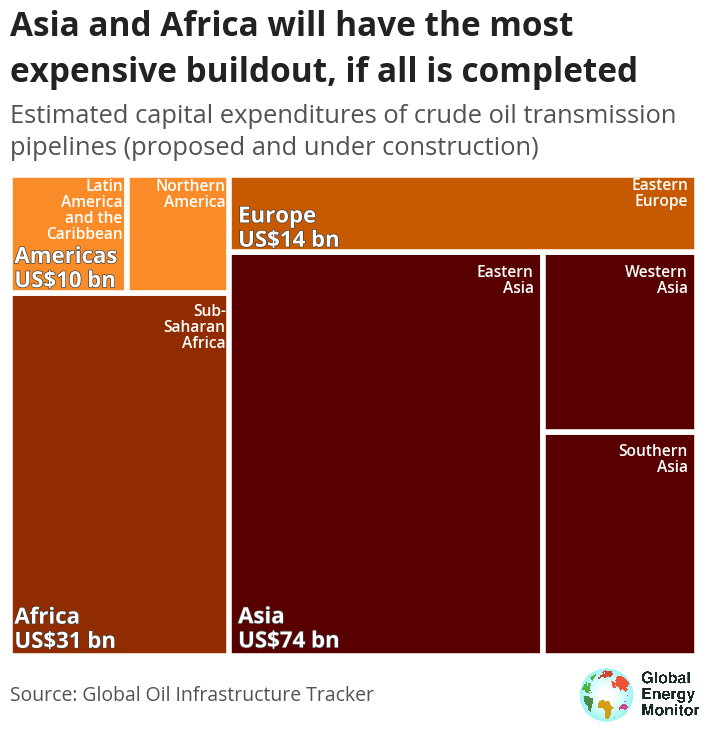

In [358]:
width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
axis_text_color = '0.5'

ax=fig.add_subplot(111)
ax.axis('off')

which_status = 'proposed+construction'
subregion_divider_lw = 4
region_divider_lw = 3
divider_lc = '1'

capex_by_subregion_df_nozero = capex_by_subregion_df.loc[capex_by_subregion_df[which_status]>1]
capex_by_region_df_nozero = capex_by_subregion_df_nozero.groupby('Region').sum()

# first normalize region sizes (computes the areas for the treemap)
normalized_region_values = squarify.normalize_sizes(capex_by_region_df_nozero.drop('Total')[which_status].values,
                                                    dx=100,
                                                    dy=100)

# squarify them now (computes where they are arranged)
squarified_region_values = squarify.squarify(normalized_region_values,
                                             x=0,
                                             y=0,
                                             dx=100,
                                             dy=100)

capex_by_subregion_df_treemap = capex_by_subregion_df_nozero.drop('Total')[[which_status]].reset_index(level=1)

ax_bbox = ax.get_position()
x_scale = ax_bbox.bounds[2]
y_scale = ax_bbox.bounds[3]

for i in range(len(squarified_region_values)):
    region_name = capex_by_region_df_nozero.index.tolist()[i]
    print(region_name)

    # create region dividers
    ax_new = fig.add_axes([squarified_region_values[i]['x']/100*y_scale+ax_bbox.bounds[0],
                           squarified_region_values[i]['y']/100*y_scale+ax_bbox.bounds[1],
                           squarified_region_values[i]['dx']/100*x_scale,
                           squarified_region_values[i]['dy']/100*y_scale],
                          frameon=True,
                          transform=ax.transAxes)

    # pull out subregion values
    subregion_values_df = capex_by_subregion_df_treemap.loc[region_name]
    
    if subregion_values_df[which_status].size == 1:
        subregion_values = [subregion_values_df[which_status]]
    else:
        subregion_values = subregion_values_df.sort_values(which_status, ascending=False)[which_status].values
    
    normalized_subregion_values = squarify.normalize_sizes(subregion_values,
                                                           dx=squarified_region_values[i]['dx'],
                                                           dy=squarified_region_values[i]['dy'])
    ax_new.axis('off')
    
    #subregion squarify plot
    squarify.plot(normalized_subregion_values,
                  norm_x=100,
                  norm_y=100,
                  ax=ax_new,
                  pad=False,
                  color=[treemap_colors[region_name]]*normalized_subregion_values.__len__(),
                  linewidth=subregion_divider_lw,
                  clip_on=False,
                  edgecolor=divider_lc)

    region_text = ax_new.text(
                s=region_name+'\n'+'US${x:,.0f} bn'.format(x=round(capex_by_region_df_nozero.loc[region_name,which_status],1)),
                x=list((2,2,2,2))[i],
                y=1,
                #transform=ax_new.transAxes,
                ha='left',
                va='bottom',
                #wrap=True,
                size=font_size_axis,
                color='1',
                weight=text_weight_bold)
    region_text.set_path_effects([matplotlib.patheffects.withStroke(linewidth=1, foreground='0.25')])

    # for each region plot with subregions, get the rectangles (bars) of the subregions
    # final entry of bars is the full box of the plot, I think, so use N-1 of them...
    bars = [rect for rect in ax_new.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
    for j in range(bars.__len__()-1):
        # get lower left, top right corner of boxes
        x0,y0,x1,y1 = bars[j].get_bbox().x0, bars[j].get_bbox().y0, bars[j].get_bbox().x1, bars[j].get_bbox().y1
        if bars.__len__()-1 == 1:
            subregion_string = subregion_values_df.Subregion
        else:
            subregion_string = subregion_values_df.iloc[j].Subregion
        text = ax_new.text(x=x1-2,y=y1-3,
                    s='\n'.join(
                        textwrap.wrap(
                        subregion_string,
                        10,
                        break_long_words=False)
                    ),
                    size=font_size_axis*0.7,
                    color='1',
                    ha='right',
                    va='top',
                    weight=600,
                    linespacing=1)

# fig.tight_layout()
sub_text = textwrap.fill('Estimated capital expenditures of crude oil transmission pipelines (proposed and under construction)',59)
tit_text = textwrap.fill('Asia and Africa will have the most expensive buildout, if all is completed',40)

gemplot_title_subtitle(ax=ax, fig=fig,
                       title_text=tit_text,
                       subtitle_text=sub_text,vertical_shift=0.03)

gemplot_footer(ax=ax, fig=fig,
               footer_text='Source: Global Oil Infrastructure Tracker',
               footer_position=0.75
              )

gemplot_axes(ax=ax, fig=fig)

fig.savefig('./figures/capex-treemap-horiz-text.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)
fig.savefig('./figures/capex-km-treemap-horiz-text.pdf', 
            bbox_inches='tight',
            transparent=False)

In [308]:
bars.__len__()-1

2

In [301]:
subregion_values_df

Subregion                Sub-Saharan Africa
proposed+construction                31.324
Name: Africa, dtype: object

In [281]:
subregion_values_df.iloc[0].Subregion

'Latin America and the Caribbean'

In [282]:
subregion_values_df.iloc[1].Subregion

'Northern America'

# km by country, capex by country

In [110]:
capex_by_country_df.loc['Sri Lanka']

proposed                0.022
construction            0.000
proposed+construction   0.022
shelved                 0.000
cancelled               0.000
operating               0.010
idle                    0.000
mothballed              0.000
retired                 0.000
Name: Sri Lanka, dtype: float64

In [111]:
km_by_country_df.loc['Sri Lanka']

Region                            Asia
Subregion                Southern Asia
proposed                        12.470
construction                     0.000
proposed+construction           12.470
shelved                          0.000
cancelled                        0.000
operating                        5.800
idle                             0.000
mothballed                       0.000
retired                          0.000
Name: Sri Lanka, dtype: object

In [112]:
capex_by_country_df.loc['Iraq']

proposed                28.254
construction             0.249
proposed+construction   28.503
shelved                  0.000
cancelled                2.989
operating               13.908
idle                     0.000
mothballed               2.709
retired                  0.000
Name: Iraq, dtype: float64

In [113]:
km_by_country_df.loc['Iraq']

Region                           Asia
Subregion                Western Asia
proposed                    3,755.660
construction                   75.000
proposed+construction       3,830.660
shelved                         0.000
cancelled                     898.800
operating                   5,241.730
idle                            0.000
mothballed                    935.150
retired                         0.000
Name: Iraq, dtype: object

In [114]:
km_and_capex_by_country = km_by_country_df[['proposed+construction']].copy()
km_and_capex_by_country = km_and_capex_by_country.rename(columns={'proposed+construction':'proposed+construction km'})
km_and_capex_by_country['proposed+construction capex'] = capex_by_country_df[['proposed+construction']]
km_and_capex_by_country.replace(numpy.nan,'',inplace=True)
km_and_capex_by_country.to_excel('km-and-capex-by-country.xlsx')

In [115]:
km_and_capex_by_country

,proposed+construction km,proposed+construction capex
China,"4,356.650",11.376
Iraq,"3,830.660",28.503
Iran,"2,977.000",5.395
India,"2,824.000",4.045
Syria,"2,140.410",9.904
...,...,...
Ethiopia,0.000,0.000
France,0.000,0.000
Gabon,0.000,0.000
Georgia,0.000,0.000


## capex data - 15 leading countries by construction

In [ ]:
country_order

In [ ]:
km_by_country_df.sort_values('construction', ascending=False)[:15]

In [ ]:
nbars = 15
country_order = km_by_country_df.sort_values('proposed+construction', ascending=False).index.tolist()[:nbars]
capex_by_country_df.loc[country_order]

## print out country-level stranded assets for report discussion

## in-dev for each country in list

# us infrastructure km and cost for Gulf Coast export buildout specifically

# numbers for report

## amount already being constructed

In [ ]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['construction']/km_by_country_total['proposed+construction']

## capacity/potential emissions in development globally

In [ ]:
pipes_df_subset.CapacityBOEd

## total number of pipelines in dev - disagrees a little bit with country_ratios version

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                  (pipes_df_orig.Status.isin(['proposed','construction']))]['LengthMergedKm'].sum()

## top 10 pipelines

## biggest pipelines that went into construction in 2022/2023

In [ ]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                                                                  (pipes_df_orig.Status.isin(['construction','operating']))&
                                                                  (pipes_df_orig.ConstructionYear.isin([2023,2024]))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

## biggest pipeline projects by name in China, rather than individual ProjectID

In [ ]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                                                                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                                                                  (pipes_df_orig.Countries.str.contains('China'))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                (pipes_df_orig.Status.isin(['construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].shape

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                (pipes_df_orig.Status.isin(['construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].LengthMergedKm.mean()

## km of pipeline with 2023, 2024 start years

In [ ]:
# for the key points
print(pipes_indev_startyear.loc['construction',2024],
      pipes_indev_startyear.loc['construction',2025])

print(pipes_indev_startyear.loc['proposed',2024],
      pipes_indev_startyear.loc['proposed',2025])

## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations

In [ ]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['proposed','construction'])) &
        (pipes_df_calc.Fuel.isin(oil_fuel_options))]['LengthMergedKm'].sum()

In [ ]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc.Fuel.isin(oil_fuel_options)) &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['proposed','construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [ ]:
country_ratios_df[(country_ratios_df['Status'].isin(['proposed','construction'])) &
               (country_ratios_df.Fuel.isin(oil_fuel_options))]['MergedKmByCountry'].sum()

## num in dev globally, whether capacity expansions or not

In [ ]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (~pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

In [ ]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])

print(pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                  (pipes_df_orig.Status.isin(['proposed','construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

# delay/difficulty to build analysis

### delays in 2023

In [ ]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status'])['LengthMergedKm'].sum()

In [ ]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
                    (pipes_df_orig.StartYearEarliest==2024)].groupby(['Status','StartRegion'])['LengthMergedKm'].sum()

### timeline of pipeline completion

In [ ]:
# timeline of pipeline completion?
# need both proposal year and needs to be operational and have a start year
pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
    (pipes_df_orig.Status=='operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
pipes_df_gas_with_completion_data = pipes_df_orig.loc[(pipes_df_orig.Fuel.isin(oil_fuel_options))&
    (pipes_df_orig.Status=='operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')&
    (pipes_df_orig.ProposalYear!=pipes_df_orig.StartYearEarliest)]

# km of projects built in past 5 years, 10 years?